In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv']


## Explore Folder Structure

In [2]:
base_dir = "../input"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
num_classes = len(os.listdir(train_dir))
print("Training folder contains", len(os.listdir(train_dir)), "folders(classes of images)")
print("Testing folder contains", len(os.listdir(test_dir)), "images")

Training folder contains 43 folders(classes of images)
Testing folder contains 12631 images


In [3]:
train_dataframe = pd.read_csv("../input/Train.csv")
test_dataframe = pd.read_csv("../input/Test.csv")
train_dataframe.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


## Keep only filenames in "Path" column

In [4]:
train_dataframe["image"] = train_dataframe["Path"].apply(lambda x: x.split("/")[-1])
test_dataframe["image"] = test_dataframe["Path"].apply(lambda x: x.split("/")[-1])
train_dataframe["ClassId"] = train_dataframe["ClassId"].apply(lambda x: str(x))
test_dataframe["ClassId"] = test_dataframe["ClassId"].apply(lambda x: str(x))

train_dataframe.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,image
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,00020_00000_00004.png


## Understand the dataset Distribution

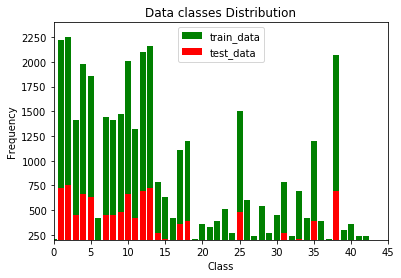

In [5]:
class_freq = pd.DataFrame()
class_freq["ClassId"], class_freq["freq"] = train_dataframe.ClassId.value_counts().index.astype(int), train_dataframe.ClassId.value_counts().values
class_freq["test_ClassId"], class_freq["test_freq"] = test_dataframe.ClassId.value_counts().index.astype(int), test_dataframe.ClassId.value_counts().values

import matplotlib.pyplot as plt

plt.title("Data classes Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xlim(0, 45)
plt.ylim(200, 2400)
plt.bar(class_freq["ClassId"], class_freq["freq"], color="green", label="train_data")
plt.bar(class_freq["test_ClassId"], class_freq["test_freq"], color="red", label="test_data")
plt.legend(loc='best')
plt.show()

## Loading Image data using ImageDataGenerator

In [6]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,zoom_range=0.2, horizontal_flip=True,
                                   validation_split=0.20)

training_set = train_datagen.flow_from_directory(
                                                directory = train_dir,
                                                target_size=(48, 48),
                                                subset="training",
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode="categorical")

val_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size=(48, 48),
                                                    subset="validation",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical")

Using TensorFlow backend.


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## Understanding Image Shape distribution

In [7]:
from tqdm import tqdm_notebook
training_images = training_set.filenames

shape = []
for image in tqdm_notebook(train_dataframe["Path"]):
    image = image.lower()
    image = os.path.join(base_dir, image)
    img = plt.imread(image)
    h, w, c = img.shape
    shape.append((image, h, w, c))

shapes = pd.DataFrame(shape, columns=["Image", "Height", "Width", "Channels"])

## Distribution of Heights in images

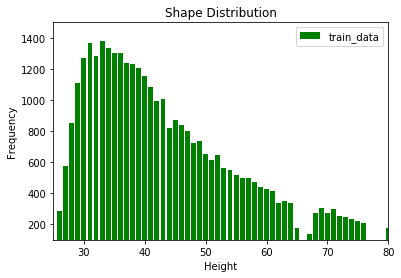

In [8]:
shape_freq = pd.DataFrame()
shape_freq["shape"], shape_freq["freq"] = shapes.Height.value_counts().index.astype(int), shapes.Height.value_counts().values

# Height vs counts
plt.title("Shape Distribution")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.xlim(25, 80)
plt.ylim(100, 1500)
plt.bar(shape_freq["shape"], shape_freq["freq"], color="green", label="train_data")
plt.legend(loc='best')
plt.show()

## Distribution of Width in images

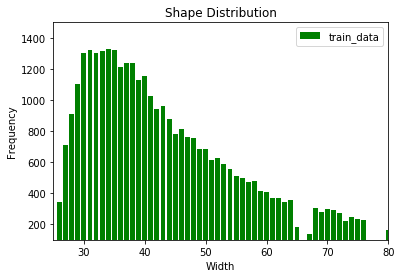

In [9]:
shape_freq = pd.DataFrame()
shape_freq["shape"], shape_freq["freq"] = shapes.Width.value_counts().index.astype(int), shapes.Width.value_counts().values

# Width vs counts
plt.title("Shape Distribution")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.xlim(25, 80)
plt.ylim(100, 1500)
plt.bar(shape_freq["shape"], shape_freq["freq"], color="green", label="train_data")
plt.legend(loc='best')
plt.show()

In [10]:
import tensorflow as tf
from tensorflow import keras

n_epochs = 100
n_channels = 3
s = [1, 1, 1, 1]
pad = "SAME"
pool = [1, 2, 2, 1]
s_pool = [1, 2, 2, 1]
keep_prob = 0.5

tf.reset_default_graph()
sess = tf.Session()

In [11]:
X = tf.placeholder(name="X", shape=(None, 48, 48, n_channels), dtype=tf.float32)
Y = tf.placeholder(name="Y", shape=(None, 43), dtype=tf.float32)

In [12]:
def initialize_parameters(layer=None, kernel_size=3, n_channels=None, n_filters=None):
    w_name = "W" + str(layer)
    b_name = "b" + str(layer)
    W = tf.get_variable(name=w_name, shape=[kernel_size,
                         kernel_size, n_channels, n_filters],
                        dtype=tf.float32,
                         initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(0.01))

    b = tf.get_variable(name=b_name, dtype=tf.float32,
                     initializer=tf.constant(0.01, dtype=tf.float32,
                     shape=[n_filters]))

    return W, b

## First Convolution Layer
### Here we only increase the depth in convolution layer, Height and Width remains same
* kernel_size <-- 3 * 3
* stride <-- 1
* filters <-- 16
* padding <-- "same"
* activation <-- "relu"

## Pooling Layer
### Reduce Height and Weight by a factor of 2
* ksize <-- 2 * 2
* stride <-- 2

In [13]:
ksize_filter_1 = 3
n_filters_1 = 16

# initialize Weights and Biases for layer 1
W1, b1 = initialize_parameters(layer=1, kernel_size=ksize_filter_1, n_channels=n_channels, n_filters=n_filters_1)

Z1 = tf.nn.conv2d(X, W1, strides=s, padding=pad)
Z1 = tf.add(Z1, b1)
A1 = tf.nn.relu(Z1)

A1 = tf.nn.max_pool(A1, ksize=pool, strides=s_pool, padding="VALID")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


## Second Convolution Layer
### Here we only increase the depth in convolution layer, Height and Width remains same
* kernel_size <-- 3 * 3
* stride <-- 1
* filters <-- 32
* padding <-- "same"
* activation <-- "relu"

## Pooling Layer
### Reduce Height and Weight by a factor of 2
* ksize <-- 2 * 2
* stride <-- 2


In [14]:
ksize_filter_2 = 3
n_filters_2 = 32

# initialize Weights and Biases for layer 2
W2, b2 = initialize_parameters(layer=2, kernel_size=ksize_filter_2, n_channels=n_filters_1, n_filters=n_filters_2)

Z2 = tf.nn.conv2d(A1, W2, strides=s, padding=pad)
Z2 = tf.add(Z2, b2)
A2 = tf.nn.relu(Z2)

A2 = tf.nn.max_pool(A2, ksize=pool, strides=s_pool, padding="VALID")

## Third Convolution Layer
### Here we only increase the depth in convolution layer, Height and Width remains same
* kernel_size <-- 3 * 3
* stride <-- 1
* filters <-- 64
* padding <-- "same"
* activation <-- "relu"

## Pooling Layer
### Reduce Height and Weight by a factor of 2
* ksize <-- 2 * 2
* stride <-- 2

In [15]:
ksize_filter_3 = 3
n_filters_3 = 64

# initialize Weights and Biases for layer 3
W3, b3 = initialize_parameters(layer=3, kernel_size=ksize_filter_3, n_channels=n_filters_2, n_filters=n_filters_3)

Z3 = tf.nn.conv2d(A2, W3, strides=s, padding=pad)
Z3 = tf.add(Z3, b3)
A3 = tf.nn.relu(Z3)

A3 = tf.nn.max_pool(A3, ksize=pool, strides=s_pool, padding="VALID")

## Fourth Convolution Layer
### Here we only increase the depth in convolution layer, Height and Width remains same
* kernel_size <-- 3 * 3
* stride <-- 1
* filters <-- 128
* padding <-- "same"
* activation <-- "relu"

## Pooling Layer
### Reduce Height and Weight by a factor of 2
* ksize <-- 2 * 2
* stride <-- 2

In [16]:
ksize_filter_4 = 3
n_filters_4 = 128

# initialize Weights and Biases for layer 4
W4, b4 = initialize_parameters(layer=4, kernel_size=ksize_filter_4, n_channels=n_filters_3, n_filters=n_filters_4)

Z4 = tf.nn.conv2d(A3, W4, strides=s, padding=pad)
Z4 = tf.add(Z4, b4)
A4 = tf.nn.relu(Z4)

A4 = tf.nn.max_pool(A4, ksize=pool, strides=s_pool, padding="VALID")

# Network in Network Convolution
# Reduces the depth for easier computation
* kernel_size <-- 1 * 1
* stride <-- 1
* filters <-- 32
* padding <-- "same"
* activation <-- "relu"

In [17]:
ksize_filter_5 = 1
n_filters_5 = 32

# initialize Weights and Biases for layer 5
W5, b5 = initialize_parameters(layer=5, kernel_size=ksize_filter_5, n_channels=n_filters_4, n_filters=n_filters_5)

Z5 = tf.nn.conv2d(A4, W5, strides=s, padding=pad)
Z5 = tf.add(Z5, b5)
A5 = tf.nn.relu(Z5)

# Flatten Layer followed by Fully Connected Layers


In [18]:
# use A5 if network in network to be used, helps in reducing computational cost
# use A5 for without 1 * 1 convolution implemenatation
layer_shape = A4.get_shape()
num_features = layer_shape[1:4].num_elements()
flatten = tf.reshape(A4, [-1, num_features])
fc1_in = flatten.get_shape()[1:4].num_elements()

FCW1 = tf.get_variable(name="FCW1", shape=[fc1_in, 1024], dtype=tf.float32,
                       initializer=tf.contrib.layers.xavier_initializer(),
                       regularizer=tf.contrib.layers.l2_regularizer(0.01))
FCb1 = tf.get_variable(name="FCb1", shape=[1, 1024], dtype=tf.float32,
                       initializer=tf.contrib.layers.xavier_initializer(),
                       regularizer=tf.contrib.layers.l2_regularizer(0.01))

FC1 = tf.add(tf.matmul(flatten, FCW1), FCb1)
FC1 = tf.nn.relu(FC1)
FC1 = tf.nn.dropout(FC1, keep_prob)

FCW2 = tf.get_variable(name="FCW2", shape=[1024, 256], dtype=tf.float32,
                                   initializer=tf.contrib.layers.xavier_initializer(),
                                   regularizer=tf.contrib.layers.l2_regularizer(0.01))
FCb2 = tf.get_variable(name="FCb2", shape=[1, 256], dtype=tf.float32,
                                   initializer=tf.contrib.layers.xavier_initializer(),
                                   regularizer=tf.contrib.layers.l2_regularizer(0.01))

FC2 = tf.add(tf.matmul(FC1, FCW2), FCb2)
FC2 = tf.nn.relu(FC2)
FC2 = tf.nn.dropout(FC2, keep_prob)

FCW3 = tf.get_variable(name="FCW3", shape=[256, 43], dtype=tf.float32,
                                   initializer=tf.contrib.layers.xavier_initializer(),
                                    regularizer=tf.contrib.layers.l2_regularizer(0.01))
FCb3 = tf.get_variable(name="FCb3", shape=[1, 43], dtype=tf.float32,
                                   initializer=tf.contrib.layers.xavier_initializer(),
                                    regularizer=tf.contrib.layers.l2_regularizer(0.01))

FC3 = tf.add(tf.matmul(FC2, FCW3), FCb3)


# Prediction
prediction = tf.argmax(FC3,1)
pred_prob = tf.nn.softmax(FC3)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Cost Function and Optimization

In [19]:
# Loss Function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=FC3, labels=Y)

# Cost function
cost = tf.reduce_mean(cross_entropy)

# Evaluate model -- Accuracy
correct_pred = tf.equal(prediction, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [20]:
# number of batches
nb_train = int(len(training_set.filenames) / batch_size) if len(training_set.filenames) % batch_size == 0 else int(len(training_set.filenames) / batch_size) + 1
nb_val = int(len(val_set.filenames) / batch_size) if len(val_set.filenames) % batch_size == 0 else int(len(val_set.filenames) / batch_size) + 1

print("Training batches:", nb_train)
print("val_batches:", nb_val)

Training batches: 246
val_batches: 62


## Train the model

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
best_acc = 0
history = []

with tf.Session() as sess:
    sess.run(init)
    for i in tqdm_notebook(range(n_epochs)):
        step = 0
        total_loss = 0
        total_acc = 0
        val_total_loss = 0
        val_total_acc = 0
        for batch in range(nb_train):
            batch_X, batch_Y = training_set.next()
            # Optimize
            sess.run(optimizer, feed_dict={X : batch_X, Y : batch_Y})
            if batch % 60 == 0:
                # measure and display training accuracy and loss
                train_loss, train_acc = sess.run([cost, accuracy], feed_dict={X : batch_X, Y : batch_Y})
                total_loss += train_loss
                total_acc += train_acc
                print("For Minibatch:", str(batch), "at epoch:", str(i), "Loss:",train_loss,
                      " and acc:", train_acc)
                step += 1
        total_loss /= step
        total_acc /= step
        
        for batch in range(nb_val):
            val_batch_X, val_batch_Y = val_set.next()
            # measure and display validation accuracy and loss
            val_loss, val_acc = sess.run([cost, accuracy], feed_dict={X : val_batch_X, Y : val_batch_Y})
            val_total_loss += val_loss
            val_total_acc += val_acc
        
        val_total_loss /= nb_val
        val_total_acc /= nb_val        
        print("After Epoch", str(i), "Validation Loss:", val_total_loss,
                                      " Validation Acc:", val_total_acc)
    
        history.append((i, total_loss, total_acc, val_total_loss, val_total_acc))
        
        if  val_total_acc > 0.3 and val_total_acc > best_acc:
            best_acc = val_total_acc
            try:
                save_path = saver.save(sess, "/kaggle/working/gtsr_model.cpkt")
                print("Model Stored in path:", save_path)
            except Exception as e:
                print("Model Not stored")
                print(e)
    print("Optimization is DONE!!!!!")
    
try:
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "/kaggle/working/gtsr_model.cpkt")
        print("Model Restored")
except:
    print("Model Not restored")

For Minibatch: 0 at epoch: 0 Loss: 3.6759472  and acc: 0.0703125
For Minibatch: 60 at epoch: 0 Loss: 3.3158665  and acc: 0.1015625
For Minibatch: 120 at epoch: 0 Loss: 2.6235805  and acc: 0.234375
For Minibatch: 180 at epoch: 0 Loss: 2.0332294  and acc: 0.3984375
For Minibatch: 240 at epoch: 0 Loss: 1.6896753  and acc: 0.3984375
After Epoch 0 Validation Loss: 2.2200706274278703  Validation Acc: 0.326303610878606
Model Stored in path: /kaggle/working/gtsr_model.cpkt
For Minibatch: 0 at epoch: 1 Loss: 1.7512363  and acc: 0.453125
For Minibatch: 60 at epoch: 1 Loss: 1.7347786  and acc: 0.4453125
For Minibatch: 120 at epoch: 1 Loss: 1.5071995  and acc: 0.4609375
For Minibatch: 180 at epoch: 1 Loss: 1.1544061  and acc: 0.6015625
For Minibatch: 240 at epoch: 1 Loss: 1.0878508  and acc: 0.6484375
After Epoch 1 Validation Loss: 1.6794038280364005  Validation Acc: 0.48513868547254996
Model Stored in path: /kaggle/working/gtsr_model.cpkt
For Minibatch: 0 at epoch: 2 Loss: 1.3786194  and acc: 0.5

# Plot Accuracy


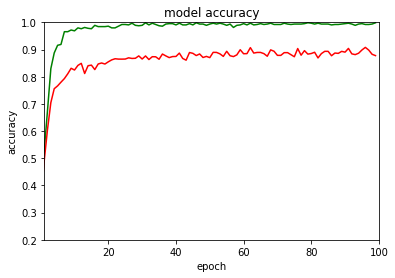

,epoch,train_loss,train_acc,val_loss,val_acc
95,95,0.021938,0.995313,0.930060,0.898453
96,96,0.026268,0.992188,0.856352,0.907949
97,97,0.015307,0.992188,0.778008,0.897964
98,98,0.018104,0.993750,1.216377,0.882511
99,99,0.005582,0.998437,1.231924,0.877677


In [22]:
import matplotlib.pyplot as plt

history = pd.DataFrame(history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

#  "Accuracy"
plt.ylim(0.2,1)
plt.xlim(1,n_epochs)
plt.plot(history[:]["epoch"], history[:]["train_acc"], label="training_accuracy", color="green")
plt.plot(history[:]["epoch"], history[:]["val_acc"], label="val_accuracy", color="red")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

history.tail()

## Plot Loss

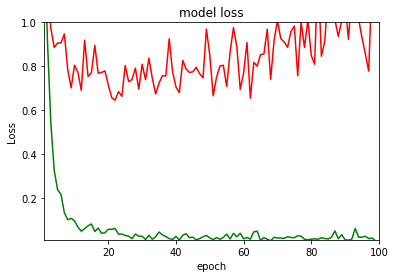

In [23]:
#  "Loss"
plt.ylim(0.01, 1)
plt.xlim(1,n_epochs)
plt.plot(history[:]["epoch"], history[:]["train_loss"], label="training_loss", color="green")
plt.plot(history[:]["epoch"], history[:]["val_loss"], label="val_loss", color="red")
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

# Predict

Testing Images
Testing: Images found  12631



test output generated: test_output.csv


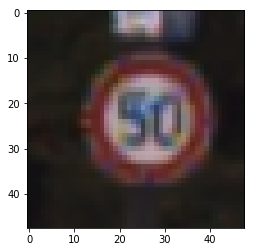

In [24]:
import cv2
import glob

print("Testing Images")
preds = []

test_set = os.listdir(test_dir)
print("Testing: Images found ", len(test_set))
with tf.Session() as sess:
    sess.run(init)
    for image in tqdm_notebook(test_set):
        if image.endswith(".png"):
            image = os.path.join(test_dir, image)
            img = cv2.imread(image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (48, 48))
            plt.imshow(img)
            img = img / 255
            img = img.reshape((-1, 48, 48, 3))
            pred = sess.run(prediction, feed_dict={X:img})
            preds.append([image.split("/")[-1], pred])
test_output = pd.DataFrame(preds, columns=["image", "pred_ClassId"])
test_output["pred_ClassId"] = test_output["pred_ClassId"].apply(
                                    lambda x : str(x).replace("[", "").replace("]", "")) 
try:
    test_output.to_csv("/kaggle/working/test_output.csv")
    print("test output generated: test_output.csv",)
except:
    print("Test output not generated")

In [25]:
test_df = pd.merge(test_dataframe, test_output, on=["image"], how="inner")
test_df["ClassId"] = test_df["ClassId"].apply(lambda x : str(x))